## Data Preprocessing

#### 1.数据质量问题
#### 较差的数据质量可能会对数据挖掘产生不利影响。常见的数据质量问题包括噪声、异常值、缺失值和重复数据。
#### 数据：breast+cancer+wisconsin+original/breast-cancer-wisconsin.data

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('./data/breast+cancer+wisconsin+original/breast-cancer-wisconsin.data', header=None)
data.columns = ['Sample code', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                'Normal Nucleoli', 'Mitoses','Class']
# 打印数据集实例个数和属性个数
print(f'实例个数：{data.shape[0]}，属性个数：{data.shape[1] - 1}')

实例个数：699，属性个数：10


##### 1.1缺失值
##### 缺失值在数据集中编码为“?”，将缺失值转换为NaN，并计算每列数据中缺失值的数量。

In [2]:
data1 = data.copy(deep=True)
data1.replace('?', np.NaN, inplace=True)
print(data1.isna().sum())

Sample code                     0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64


In [3]:
# 将缺失值替换为该列的中值
data2 = data1.copy(deep=True).astype(float)

for column in data2.columns:
    median = data2[column].median()
    data2[column] = data2[column].fillna(median)

In [4]:
# 丢弃包含缺失值的数据点，并打印丢弃后数据集的数据量
data3 = data1.copy(deep=True)
data3.dropna(inplace=True)
print(data3.shape[0])

683


##### 1.2异常值
##### 通过绘制boxplot来识别数据中包含异常值的列
##### 由于“Bare Nuclei”列中的值存储为字符串对象，应该先将该列转换为数值

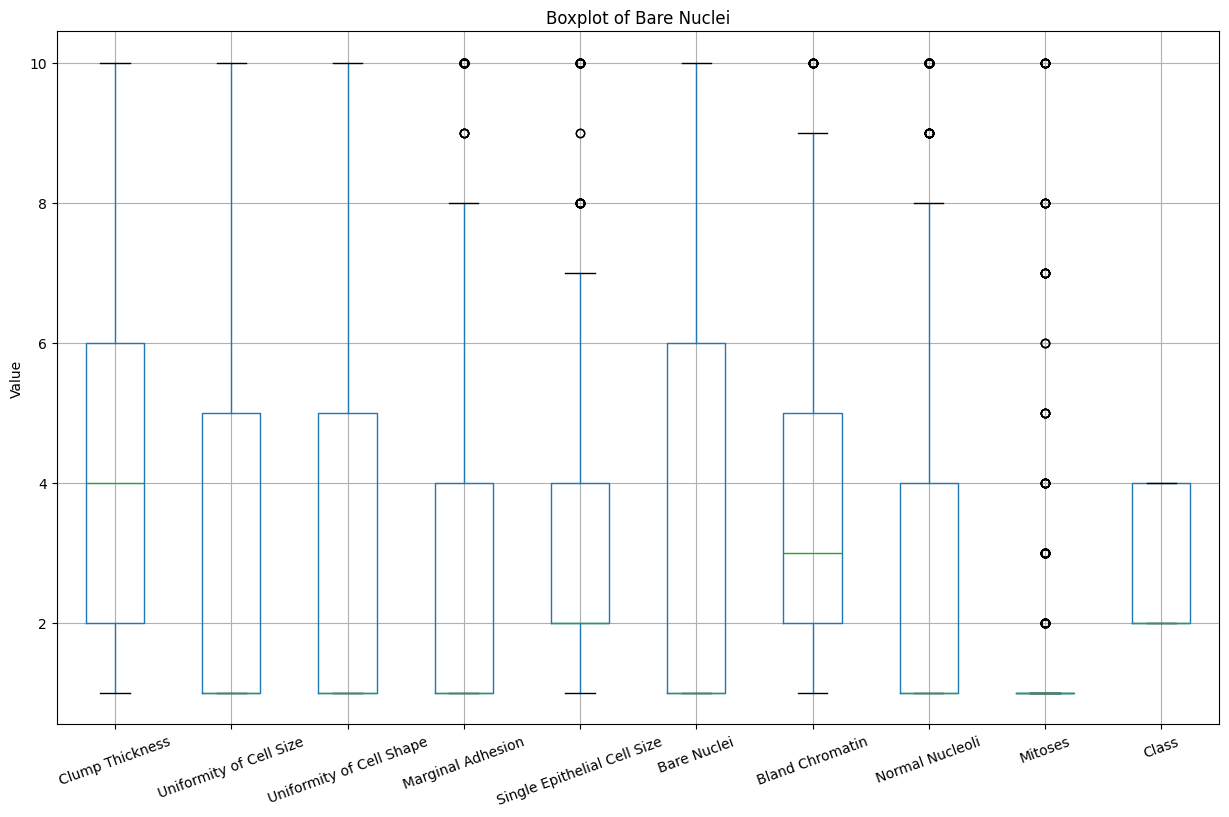

In [5]:
# 将Bare Nuclei属性的值转换为数值，利用boxplot绘制箱线图
import matplotlib.pyplot as plt

data4 = data1.copy(deep=True)
data4['Bare Nuclei'] = pd.to_numeric(data4['Bare Nuclei'], errors='coerce')
data_boxplot = data4.drop(columns=['Sample code'])

plt.figure(figsize=(15, 9))
data_boxplot.boxplot()
plt.ylabel('Value')
plt.xticks(rotation=20)
plt.title('Boxplot of Bare Nuclei')
plt.grid(True)
plt.savefig('./boxplot.jpg', dpi=1000)
plt.show()

##### 为了丢弃异常值，我们可以计算每个属性的Z分数，并删除那些包含Z分数异常高或异常低的属性的实例（例如，如果Z>3或Z<=-3）。

In [6]:
# 数据标准化，计算Z分数
data5 = data1.copy(deep=True)
data5['Bare Nuclei'] = pd.to_numeric(data5['Bare Nuclei'], errors='coerce')
data5_now = data5.drop(columns=['Sample code'])

Z = (data5_now - data5_now.mean()) / data5_now.std()
Z

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0.206788,-0.699494,-0.742767,-0.632794,-0.549168,-0.698341,-0.179534,-0.611387,-0.343666,-0.724878
1,0.206788,0.283642,0.266684,0.768071,1.708882,1.771569,-0.179534,-0.283909,-0.343666,-0.724878
2,-0.503505,-0.699494,-0.742767,-0.632794,-0.549168,-0.423907,-0.179534,-0.611387,-0.343666,-0.724878
3,0.561934,1.594490,1.612618,-0.632794,-0.097558,0.124962,-0.179534,1.353485,-0.343666,-0.724878
4,-0.148359,-0.699494,-0.742767,0.067638,-0.549168,-0.698341,-0.179534,-0.611387,-0.343666,-0.724878
...,...,...,...,...,...,...,...,...,...,...
694,-0.503505,-0.699494,-0.742767,-0.632794,-0.097558,-0.423907,-0.999756,-0.611387,-0.343666,-0.724878
695,-0.858651,-0.699494,-0.742767,-0.632794,-0.549168,-0.698341,-0.999756,-0.611387,-0.343666,-0.724878
696,0.206788,2.249915,2.285586,0.067638,1.708882,-0.149472,1.871021,2.335921,0.239398,1.377569
697,-0.148359,1.594490,0.939651,0.417854,-0.097558,0.124962,2.691243,1.026006,-0.343666,1.377569


In [7]:
# 按照“Z > 3 or Z <= -3”这个原则删除异常值，打印原始数据量和删除异常值后的数据量
drop_index = Z[(Z > 3).any(axis=1) | (Z <= -3).any(axis=1)].index
data5_after = data1.drop(drop_index)
print(f'原始数据量：{data.shape[0]}，删除异常值后数据量：{data5_after.shape[0]}')

原始数据量：699，删除异常值后数据量：648


##### 1.3重复数据

In [8]:
# 检查数据中的重复样本，打印重复样本个数
data6 = data.copy(deep=True)
dup_num = data6.duplicated().sum()
print(dup_num)

8


In [9]:
# 删除重复行，打印删除前后数据集样本量
data6.drop_duplicates(inplace=True)
print(f'删除前样本量：{data.shape[0]}，删除后样本量：{data6.shape[0]}')

删除前样本量：699，删除后样本量：691


#### 2.数据聚合
#### 目的：(1)减小要处理的数据的大小;(2)改变分析的粒度(从细粒度到粗粒度);(3)提高数据的稳定性
#### 数据：DTW_prec.csv


数据的方差为：0.05304985960912044


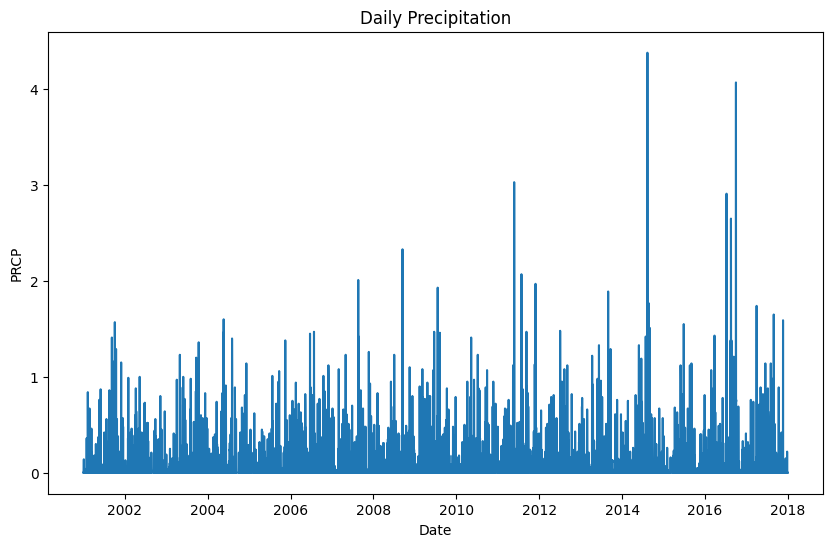

In [10]:
# 绘制其每日时间序列的折线图，并打印数据的方差
data_dtw = pd.read_csv('./data/DTW_prec.csv', header=0)
data_dtw['DATE'] = pd.to_datetime(data_dtw['DATE'])
var0 = data_dtw['PRCP'].var()
print(f'数据的方差为：{var0}')

plt.figure(figsize=(10, 6))
plt.plot(data_dtw['DATE'], data_dtw['PRCP'], linestyle='-')
plt.title('Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('PRCP')
plt.savefig('./daily.png', dpi=1000)
plt.show()

数据的方差为：2.42411605090312


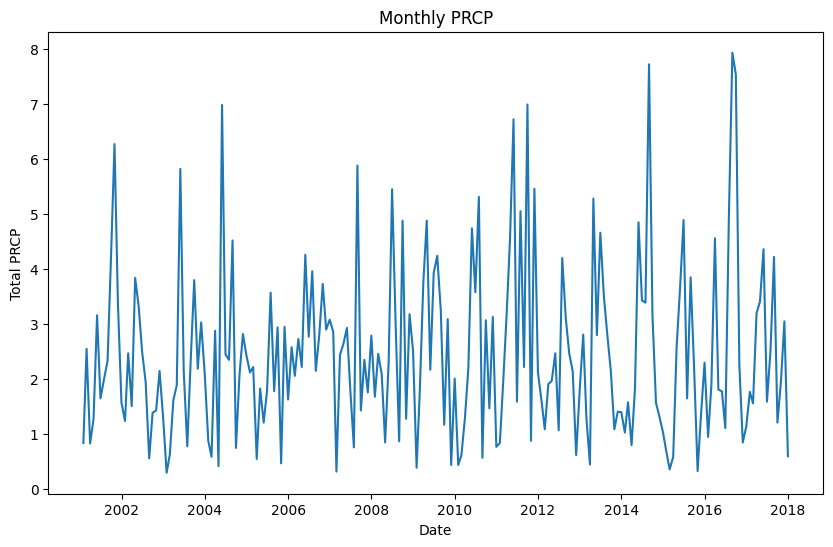

In [11]:
# 每日降水量的时间序列过于混乱，不同时间步长之间的变化很大。将其按月分组和聚合，获得月总降水量值。
# 绘制其每月时间序列的折线图，并打印数据的方差
monthly = data_dtw.groupby(pd.Grouper(key='DATE', freq='ME')).sum()
var1 = monthly['PRCP'].var()
print(f'数据的方差为：{var1}')

plt.figure(figsize=(10, 6))
plt.plot(monthly.index, monthly['PRCP'], linestyle='-')
plt.title('Monthly PRCP')
plt.xlabel('Date')
plt.ylabel('Total PRCP')
plt.savefig('./monthly.png', dpi=1000)
plt.show()

数据的方差为：23.699712499999997


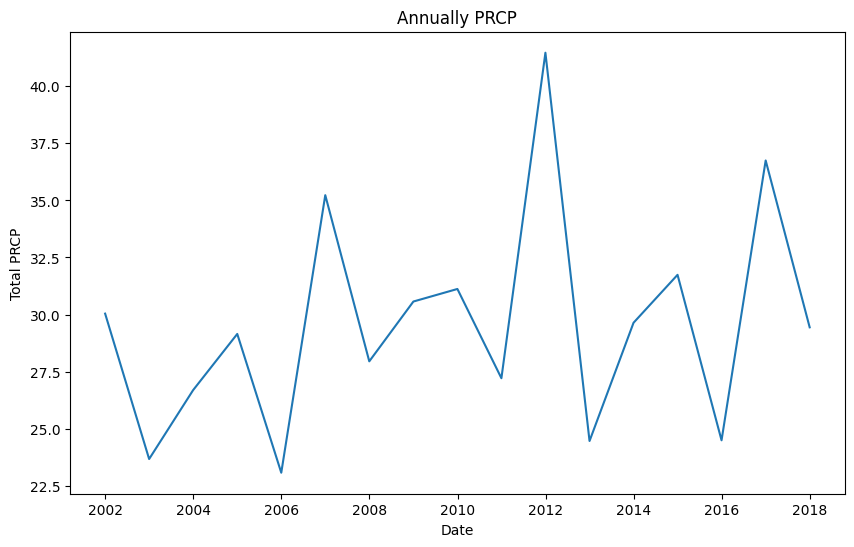

In [12]:
# 绘制其每年时间序列的折线图，并打印数据的方差
year = data_dtw.groupby(pd.Grouper(key='DATE', freq='YE')).sum()
var2 = year['PRCP'].var()
print(f'数据的方差为：{var2}')

plt.figure(figsize=(10, 6))
plt.plot(year.index, year['PRCP'], linestyle='-')
plt.title('Annually PRCP')
plt.xlabel('Date')
plt.ylabel('Total PRCP')
plt.savefig('./annually.png', dpi=1000)
plt.show()

#### 3.采样(可分为替换采样和不替换采样)
#### 不替换采样，其中每个选定实例都从数据集中删除；替换采样，每个选定实例不删除，从而允许在样本中多次选择
#### 数据：breast+cancer+wisconsin+original/breast-cancer-wisconsin.data

In [13]:
# 从原始数据中随机选择（不替换）大小为3的样本
data7 = data.copy(deep=True)
sample0 = data7.sample(n=3, replace=False)
sample0

,Sample code,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
66,1117152,4,1,1,1,2,1,3,1,1,2
69,1121732,1,1,1,1,2,1,3,2,1,2
513,1304595,3,1,1,1,1,1,2,1,1,2


In [14]:
# 随机选择1%的数据（不替换）并显示所选样本
num_sample1 = int(data7.shape[0] * 0.01)
sample1 = data7.sample(n=num_sample1, replace=False)
sample1

,Sample code,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
17,1049815,4,1,1,1,2,1,3,1,1,2
612,822829,8,10,10,10,6,10,10,10,10,4
20,1054590,7,3,2,10,5,10,5,4,4,4
670,1352848,3,10,7,8,5,8,7,4,1,4
610,736150,10,4,3,10,3,10,7,1,2,4
37,1081791,6,2,1,1,1,1,7,1,1,2


In [15]:
# （替换）采样1%的数据
num_sample2 = int(data7.shape[0] * 0.01)
sample2 = data7.sample(n=num_sample1, replace=True)
sample2

,Sample code,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
245,1287775,5,1,1,2,2,2,3,1,1,2
564,1331405,4,1,1,1,2,1,3,2,1,2
141,1183911,2,1,1,1,2,1,1,1,1,2
334,785615,8,6,7,3,3,10,3,4,2,4
290,560680,1,1,1,1,2,1,1,1,1,2
89,1155546,2,1,1,2,3,1,2,1,1,2


#### 4.离散化（将连续属性转换为分类属性）
#### 数据：breast+cancer+wisconsin+original/breast-cancer-wisconsin.data
#### 对乳腺癌症数据集中的“Clump Thickness”属性使用无监督离散方法（equal width和equal depth）

In [16]:
# 使用Counter对数据集Clump Thickness属性的取值进行计数
from collections import Counter

ct = data['Clump Thickness']
ct_count = Counter(ct)
ct_count

Counter({1: 145,
         5: 130,
         3: 108,
         4: 80,
         10: 69,
         2: 50,
         8: 46,
         6: 34,
         7: 23,
         9: 14})

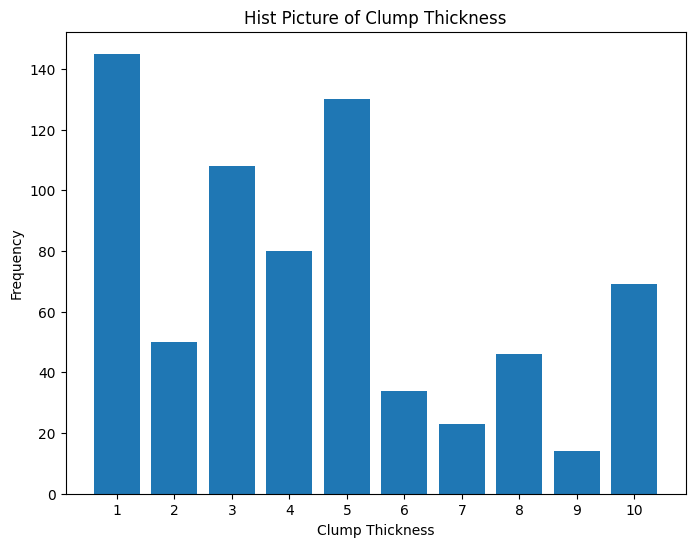

In [17]:
# 绘制直方图，显示属性值的分布
val = list(ct_count.keys())
counts = list(ct_count.values())

plt.figure(figsize=(8, 6))
plt.bar(val, counts)
plt.xlabel('Clump Thickness')
plt.ylabel('Frequency')
plt.xticks(range(1, max(val) + 1))
plt.title('Hist Picture of Clump Thickness')
plt.savefig('./hist.jpg', dpi=1000)
plt.show()

In [18]:
# equal width：应用cut()将属性离散为4个间隔宽度相似的bin
# 使用value_counts()确定每个bin中的实例数
ct_bins = pd.cut(data['Clump Thickness'], bins=4)
bin_counts = ct_bins.value_counts()
bin_counts

Clump Thickness
(0.991, 3.25]    303
(3.25, 5.5]      210
(7.75, 10.0]     129
(5.5, 7.75]       57
Name: count, dtype: int64

In [19]:
# 修改为0.99为左边界
ct_bins_new = pd.cut(data['Clump Thickness'], bins=[0.99, 3.25, 5.5, 7.75, 10])
bin_counts_new = ct_bins_new.value_counts()
bin_counts_new

Clump Thickness
(0.99, 3.25]    303
(3.25, 5.5]     210
(7.75, 10.0]    129
(5.5, 7.75]      57
Name: count, dtype: int64

In [20]:
# equal frequency：qcut()函数可用于将值划分为4个bin，以便每个bin具有几乎相同数量的实例
ct_qbins = pd.qcut(data['Clump Thickness'], q=4)
qbins_count = ct_qbins.value_counts()
qbins_count

Clump Thickness
(0.999, 2.0]    195
(2.0, 4.0]      188
(4.0, 6.0]      164
(6.0, 10.0]     152
Name: count, dtype: int64

#### 5.主成分分析（PCA）
#### PCA是一种通过将数据从其原始高维空间投影到低维空间来减少数据中属性数量的经典方法
#### PCA创建的新属性具有以下特点：(1)它们是原始属性的线性组合;(2)它们彼此正交（垂直）;(3)它们捕获数据中的最大变化量
#### 数据：pics文件夹下包含16个RGB图像文件，每个文件的大小为111×111像素

In [21]:
# 读取图像数据，将RGB图像转换为111x111x3=36963个特征值，最终得到一个16x36963的矩阵
from PIL import Image

path = './data/pics/Picture'
img_matrix = np.zeros((16, 36963))

for i in range(16):
    path1 = path + str(i + 1) + '.jpg'
    img = Image.open(path1).resize((111, 111))
    feature = np.array(img).flatten()
    img_matrix[i] = feature

print(img_matrix.shape)

(16, 36963)


In [22]:
# 使用PCA，将数据矩阵投影到其前两个主成分
# 无需编写PCA代码，直接导入sklearn.decomposition中的PCA类
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
img_pca = pca.fit_transform(img_matrix)
print(img_pca.shape)

(16, 2)


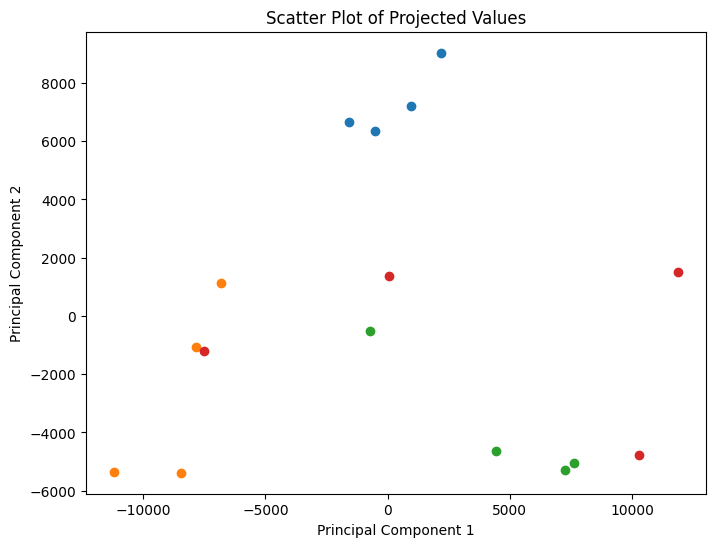

In [23]:
# 绘制散点图来显示投影值
x = img_pca[:, 0]
y = img_pca[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x[:4], y[:4])
plt.scatter(x[4:8], y[4:8])
plt.scatter(x[8:12], y[8:12])
plt.scatter(x[12:16], y[12:16])

plt.title('Scatter Plot of Projected Values')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('./scatter.png', dpi=1000)
plt.show()